- 기존 `rewrite` : 우리가 가지고 있는 문서(Vector Store) 대상 retrieve 품질 향상 위함
- Corrective RAG `rewrite` : Web Search 품질 향상 위함

https://arxiv.org/pdf/2401.15884

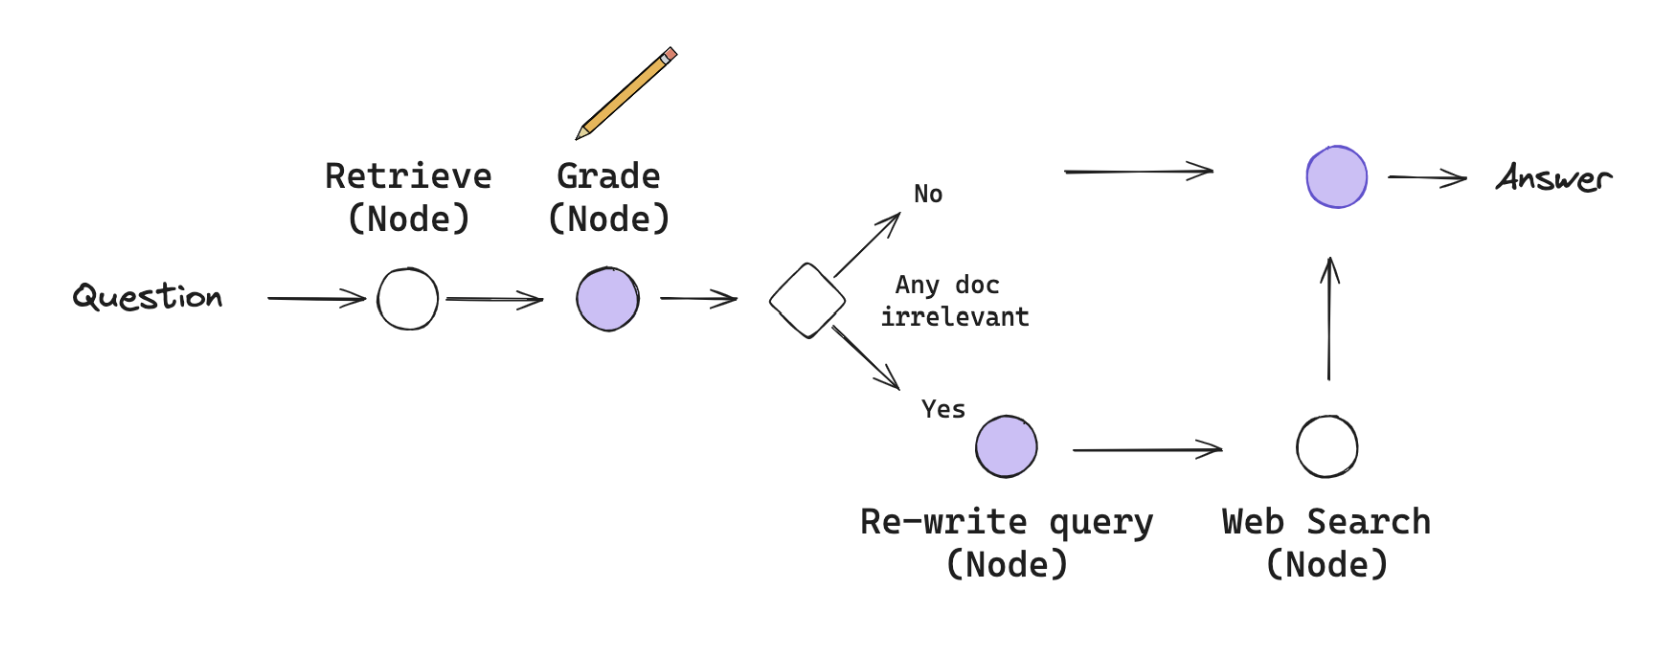

In [28]:
from dotenv import load_dotenv

load_dotenv()

True

Web Search API 필요 -> Tavily

In [29]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})


In [30]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

- Context : RAG -> Vector Store + Web Search (Tavily)

In [31]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']  
    docs = retriever.invoke(query)  
    return {'context': docs}  


In [32]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [33]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    context = state['context']  
    query = state['query']      
    
    rag_chain = generate_prompt | generate_llm | StrOutputParser()
    
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  


/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- `retrieve` 노드에서 추출된 문서와 사용자의 질문이 관련이 있는지 판단
    - 문서와 관련이 없다면 `rewrite` 노드로 이동해서 사용자의 질문을 변경
        - `rewrite` 후 다시 `web_search` 노드로 이동해서 웹 검색
    - 문서와 관련이 있다면 `generate` 노드로 이동해서 답변을 생성

In [34]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state['query']  
    context = state['context']  

    doc_relevance_chain = doc_relevance_prompt | llm
    
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        return 'relevant'
    
    return 'irrelevant'

/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [35]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser


rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    query = state['query']  
    
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    
    print(f"rewrite question == {response}")
    return {'query': response}


- `web_search` 노드에서 웹 검색을 합니다
- `retrieve` 결과 대신 웹 검색 결과를 사용합니다
    - 웹 검색 결과는 `TavilySearchResults` 툴을 사용합니다
- Langchain Tavily Tool

In [36]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

def web_search(state: AgentState) -> AgentState:
    query = state['query']
    results = tavily_search_tool.invoke(query)
    print(f"web search results == {results}")
    return {'context': results}



In [37]:
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("web_search", web_search)

In [38]:
from langgraph.graph import START, END

graph_builder.add_edge(START, "retrieve")
graph_builder.add_conditional_edges(
    "retrieve",
    check_doc_relevance,
    {
        "relevant": "generate",
        "irrelevant": "rewrite"
    }
)
graph_builder.add_edge("rewrite", "web_search")
graph_builder.add_edge("web_search", "generate")
graph_builder.add_edge("generate", END)

In [39]:
graph = graph_builder.compile()

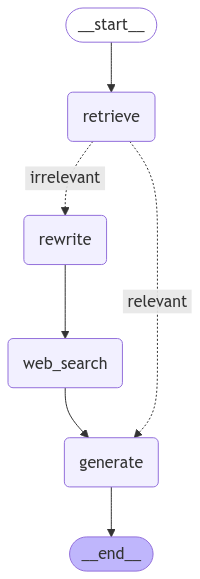

In [40]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
initial_state = {"query" : "연봉 5천만원 거주자의 소득세는 얼마인가요?"}

graph.invoke(initial_state)

{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(id='21eb49d8-11d2-4b4f-b03b-0780eea295ec', metadata={'source': './documents/income_tax.txt'}, page_content='[전문개정 2014. 1. 1.]\n제56조 세액의 계산\n<개정 2009. 12. 31.>  \n제1관 세율\n<개정 2009. 12. 31.>\n제55조(세율)\n거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.> \n| 종합소득           | 세    목                                          |\n|------------------|--------------------------------------------------|\n| 1,400만원 이하    | 과세표준의 6세부세트                               |\n| 1,400만원 초과    | 84만원 + (1,400만원을 초과하는 금액의 15세부세트) |\n| 5,000만원 이하    | 624만원 + (5,000만원을 초과하는 금액의 24세부세트) |\n| 8,800만원 이하    | 1,536만원 + (8,800만원을 초과하는 금액의 35세부세트) |\n| 1억5천만원 이하   | 3,706만원 + (1억5천만원을 초과하는 금액의 38세부세트) |\n| 3억 원 이상       | 9,406만원 + (3억원을 초과하는 금액의 40세부세트) |\n| 5억 원 이하       | 1억7,406만원 + (5억원을 초과하는 금액의 42세부세트) |\n| 10억 원 이상      | 3억6,406만원 + (1

In [43]:
initial_state = {"query" : "신논현 맛집 추천 좀"}

graph.invoke(initial_state)

rewrite question == 신논현 맛집 추천 리스트 또는 신논현 최고의 음식점
web search results == [{'url': 'https://www.diningcode.com/list.dc?query=신논현역', 'content': "'신논현역' 맛집 하이디라오 (훠궈 ★4.3), 정돈 (돈까스 ★4.5), 위트앤미트 (샌드위치 ★4.3) 등 600곳의 전체 순위,식당정보,방문자리뷰,사진 등을 확인하세요. ... 옥수수 뇨끼가 제일 맛있어서 요건 꼭 시키는거 추천👍 루꼴라파스타도 짭짤하니 맛있었어요 ㅎㅎ"}, {'url': 'https://www.diningcode.com/list.dc?query=신논현역+레스토랑', 'content': '\'신논현역 레스토랑\' 맛집 어거스트힐 (스테이크 ★4.3), 녘 (퓨전 ★4.4), 바비레드 (파스타 ★3.7) 등 25곳의 전체 순위,식당정보,방문자리뷰,사진 등을 확인하세요. ... " 신논현 근처 파스타 맛집입니다. 일층 이층으로 되어있고 자리가 넉넉해요!'}, {'url': 'https://jspringlife.com/entry/신논현역-맛집-💖-요즘-핫한-신논현역-찐-맛집-Top-10-😎🔥', 'content': '2. 신논현역 맛집💖. 엔틱정. 엔틱정 . 강남구 논현동 핫플레이스! 한겹 한겹 정성껏 담는 밀푀유나베, 최대한 신선한 재료로 가게 방문하시는 동안은 기분 좋으실 수 있게 최선을 다하겠습니다~ 안주 맛집 분위기 맛집 예쁘고 편안한 분위기 속에서 편하게 즐기며 마시고 하루 마무리하세요!'}]


{'query': '신논현 맛집 추천 리스트 또는 신논현 최고의 음식점',
 'context': [{'url': 'https://www.diningcode.com/list.dc?query=신논현역',
   'content': "'신논현역' 맛집 하이디라오 (훠궈 ★4.3), 정돈 (돈까스 ★4.5), 위트앤미트 (샌드위치 ★4.3) 등 600곳의 전체 순위,식당정보,방문자리뷰,사진 등을 확인하세요. ... 옥수수 뇨끼가 제일 맛있어서 요건 꼭 시키는거 추천👍 루꼴라파스타도 짭짤하니 맛있었어요 ㅎㅎ"},
  {'url': 'https://www.diningcode.com/list.dc?query=신논현역+레스토랑',
   'content': '\'신논현역 레스토랑\' 맛집 어거스트힐 (스테이크 ★4.3), 녘 (퓨전 ★4.4), 바비레드 (파스타 ★3.7) 등 25곳의 전체 순위,식당정보,방문자리뷰,사진 등을 확인하세요. ... " 신논현 근처 파스타 맛집입니다. 일층 이층으로 되어있고 자리가 넉넉해요!'},
  {'url': 'https://jspringlife.com/entry/신논현역-맛집-💖-요즘-핫한-신논현역-찐-맛집-Top-10-😎🔥',
   'content': '2. 신논현역 맛집💖. 엔틱정. 엔틱정 . 강남구 논현동 핫플레이스! 한겹 한겹 정성껏 담는 밀푀유나베, 최대한 신선한 재료로 가게 방문하시는 동안은 기분 좋으실 수 있게 최선을 다하겠습니다~ 안주 맛집 분위기 맛집 예쁘고 편안한 분위기 속에서 편하게 즐기며 마시고 하루 마무리하세요!'}],
 'answer': '신논현역에서 추천할 만한 맛집으로는 하이디라오(훠궈), 정돈(돈까스), 그리고 위트앤미트(샌드위치)가 있습니다. 이외에도 어거스트힐(스테이크)와 녘(퓨전) 같은 레스토랑도 좋은 선택입니다.'}

- `rewrite` 과정이 꼭 필요할까?
- 호출하는 것도 비용이 들기 때문에 굳이 필요하지 않다고 판단이 되면 호출하지 않도록 해야 함